In [592]:
# Importing necessary libraries 
import requests
import datetime
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

## Fetching Bitcoin historical price data from cryptocompare API

Max length = 2001
Max time = 83 days 09:00:00


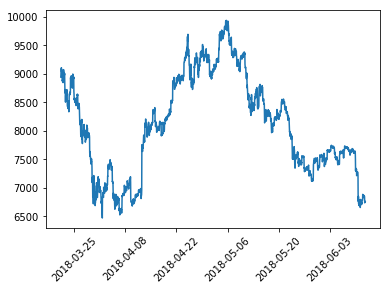

In [593]:
def hourly_price_historical(symbol, comparison_symbol, limit, aggregate, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histohour?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df.index = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df
time_delta = 1 # Bar width in hours
df = hourly_price_historical('BTC', 'USD', 2001, time_delta)
print('Max length = %s' % len(df))
print('Max time = %s' % (df.index.max() - df.index.min()))

plt.plot(df.index, df.close)
plt.xticks(rotation=45)
plt.show()

## Pre processing and Feature Engineering

In [594]:

def create_feature_dataframes(df, target_variable, shift):
    """
    Create feature dataframe where all values but the target variable are shifted and all
    remaining features are created.
    
    Returns two DataFrames X and y. Where the latter only contains the target variable.
    
    Args:
        df (pandas.DataFrame): Input DataFrame
        target_variable (str): Name of column in ``df`` that represents the target variable
        shift (int): Number of periods, all other features should be shifted back in time.
    
    Returns:
        tuple: Tuple of two DataFrames X and y, where X contains the features and y contains 
            only a single column with the target variable (column name: 'target_variable')
    """
    df = df.sort_index()
    # Copy target Variables
    df_feature = pd.DataFrame({target_variable: df[target_variable]}, index=df.index.values)
    # set last entry of the target variable to NaN
    df_feature[target_variable].iloc[-1] = np.nan
    # Now find list of feature columns (list of column names, minus target variable)
    feature_columns = set(df.columns.values).difference({target_variable})
    # Add the remaining columns back to the feature dataset but shifted.
    df_feature = pd.concat(
        [df_feature, df.loc[:, feature_columns].shift(periods=shift)],
        axis=1
    )
    
    # Create lagged features. Note that we cannot use lags < shift and only want unique lags.
    possible_lags = [shift, np.ceil((shift+1)/3)*3, np.ceil((shift+1)/6)*6, np.ceil((shift+1)/12)*12]
    # we map all values to integers, convert to set to remove duplicates and back to sorted list to
    # fixed sequence
    possible_lags = sorted(set((map(int, possible_lags))))
    for i in possible_lags:
        df_feature['Lag' + str(i)] = df_feature[target_variable].shift(periods=int(i))
    
    # add running standard deviation as feature
    df_feature['running_std'] = df_feature[target_variable].shift(periods=shift).rolling(24).std()
    # for i in range(1, 13):
     #   df_feature['running_std_{}'.format(i)] = (df_feature.index.hour == i) * df_feature['running_std']

    # Create hour features to add periodicity feature reflecting the crests and troughs during the day
    df_feature['hour_sin'] = np.sin(df_feature.index.hour/24 * 2*np.pi)
    df_feature['hour_cos'] = np.cos(df_feature.index.hour/24 * 2*np.pi)
    
    #adding the avg of opening and closing price as feature
    df_feature['avg']=(df_feature['high']+df_feature['low'])/2
    #adding the difference of opening and closing price as feature
    df_feature['diff']=df_feature['close']-df_feature['open']
    # drop rows with missing values in features, maintain the NaN Value in Target variable.
    # We have to re-collect the set of feature_columns, since we added new features since the start 
    # of this function.
    feature_columns = set(df_feature.columns.values).difference([target_variable])
    df_feature = df_feature.dropna(subset=feature_columns)

    y = df_feature.loc[:, [target_variable]].copy()  # get target variable as DataFrame
    # Rename the column in y to "target_variable"
    y = y.rename(columns={target_variable: 'target_variable'})
    # X contains all features, but the target variable
    X = df_feature.drop(target_variable, axis=1)
    
    return X, y  # return features and target variable as separate dataframes.

In [595]:
df = df[['close','open','high','low','volumefrom','volumeto']]


In [596]:
X,y = create_feature_dataframes(df,'close',1)

## Machine learning modelling function

In [597]:
def model_data(X,y,lookaheadHours):
    """Run the machine learning model on X and y to predict the corresponding LookAheadHours
       
       Returns two arrays containing the predicted value(s) for 1 or 6 Hours: (y_pred) and the last closing price
       for comparison (y_test)
       
    """
    #divide X and y into test and train datasets in 80/20 ratio
    X_train=X.head(int(0.8*len(X)))
    y_train = y.head(int(0.8*len(y)))
    X_test = X.tail(int(0.2*len(X)))
    y_test = y.tail(int(0.2*len(y)))
    
    #Support Vector Machine algorithms are not scale invariant, so it is highly recommended to scale the data.
    Xscaler = StandardScaler()
    Reg=SVR()
    # making a dict of hyper parameters for tuning the model
    param_grid = [
    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
    {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'degree':[5,10,15],'kernel': ['poly']}
     ]
    # Cross-validation according on the above parameter grid
    grid_search = GridSearchCV(Reg, param_grid, scoring="neg_mean_absolute_error",
                           cv=TimeSeriesSplit(n_splits=2, max_train_size=int(0.8*len(X_train))))
    
    grid_search.fit(Xscaler.fit_transform(X_train),y_train.values.ravel())
    # saving the tuned model
    crossvalidated_model = grid_search.best_estimator_
    
    print(crossvalidated_model,"\n")
    print("Error:",grid_search.best_score_,"\n")
    
    #Now predict for test values
    y_pred=crossvalidated_model.predict(Xscaler.fit_transform(X_test))
    
    #Plotting test values against predicted values
    y_test= y_test.rename(columns={'target_variable': 'y_true'})
    
    y_pred=pd.DataFrame({'y_pred':y_pred},index=y_test.index.values)
    y_graph= pd.concat([y_test,y_pred], axis=1)
    y_graph.plot()
    
    #And now predicting the required price(s)
    y_pred=grid_search.predict(Xscaler.fit_transform(X.tail(lookaheadHours)))
           
    return y_pred, y_test

Run the model for the next Hour prediction

SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 

Error: -0.0314132948211995 

the price is predicted to go UP in the next hour


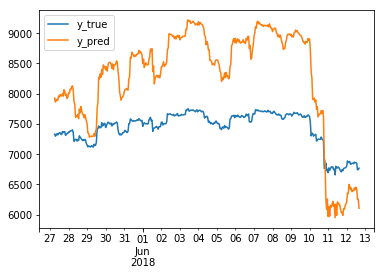

In [598]:
# Calling the modelling function for next 1 hour prediction
y_pred, y_test = model_data(X,y,1)
#Comparing the predicted price against the most recent price
if (y_pred[0] < y_test['y_true'].iloc[-1]):
   print("the price is predicted to go DOWN in the next hour")
else:
   print("the price is predicted to go UP in the next hour")

## Now repeat the process for 6 hours prediction

SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 

Error: -0.03795566591901488 

The price is predicted to go UP in t+1 hours
The price is predicted to go DOWN in t+2 hours
The price is predicted to go UP in t+3 hours
The price is predicted to go UP in t+4 hours
The price is predicted to go UP in t+5 hours
The price is predicted to go DOWN in t+6 hours


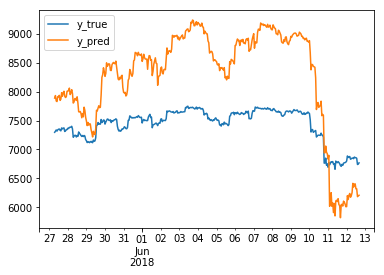

In [599]:
X,y = create_feature_dataframes(df,'close',6)
y_pred, y_test = model_data(X,y,6)
#Inserting the most recent price into the array of predict values for comparison
y_pred =np.insert(y_pred,0,y_test['y_true'].iloc[-1])
for i in range(1,7):
    if(y_pred[i]>y_pred[i-1]):
        print('The price is predicted to go UP in t+{} hours'.format(i))
    else:
        print('The price is predicted to go DOWN in t+{} hours'.format(i))